In [1]:
print(1)


1


In [ ]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from config import *
import re

### Data set-up

In [3]:
def get_sara():
    return ir_datasets.load('sara')

def sara_docs():
    for doc in sara_dataset.docs_iter():
        doc_id = doc.doc_id
        text = doc.text
        sens = doc.sensitivity
        text_method = doc.default_text()
        
        e = email.message_from_string(text_method)
        pl = e.get_payload()

        print(doc_id, sens)
        break

sara_dataset = get_sara()

In [4]:

def dataset_to_df():
    doc_ids = []
    doc_text = []
    doc_sens = []
    for doc in sara_dataset.docs_iter():
        doc_ids.append(doc.doc_id)
        doc_text.append(doc.text)
        doc_sens.append(doc.sensitivity)

    sara_dict = {'doc_id':doc_ids, 'text':doc_text, 'sensitivity':doc_sens}
    df = pd.DataFrame.from_dict(sara_dict)
    return df


sara_df = dataset_to_df()


In [5]:
testing_sample = sara_df.sample(frac=0.2, random_state=1)
value_counts = testing_sample.sensitivity.value_counts()

'''
doc_lengths = testing_sample.text.str.len()
cannot_load = testing_sample[doc_lengths > 12000]
value_counts = cannot_load.sensitivity.value_counts()
'''

doc_lengths = testing_sample.text.str.len()
temp_testing_sample = testing_sample[doc_lengths < 12000]
testing_sample = temp_testing_sample

sampled_indices = testing_sample.index
training_data = sara_df.drop(sampled_indices)

### Data Analysis

In [6]:
print(sara_df.head())

   doc_id                                               text  sensitivity
0  114715  Message-ID: <26804150.1075842955435.JavaMail.e...            0
1  229405  Message-ID: <23075367.1075853128311.JavaMail.e...            0
2  232795  Message-ID: <27422646.1075853196172.JavaMail.e...            0
3   62815  Message-ID: <4131316.1075840896739.JavaMail.ev...            0
4  118871  Message-ID: <12747077.1075843316348.JavaMail.e...            0


In [7]:
value_counts = sara_df.sensitivity.value_counts()
print(value_counts)

sensitivity
0    1491
1     211
Name: count, dtype: int64


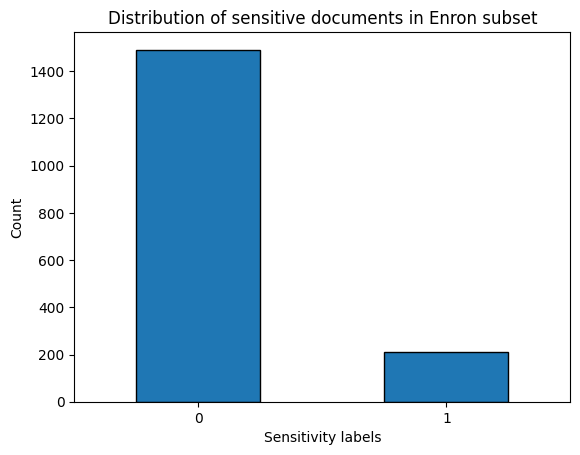

In [8]:

# Plotting the bar plot
value_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Sensitivity labels')
plt.ylabel('Count')
plt.title('Distribution of sensitive documents in Enron subset')
plt.xticks(rotation=0)
plt.show()

In [9]:
print(sara_df.text)

0       Message-ID: <26804150.1075842955435.JavaMail.e...
1       Message-ID: <23075367.1075853128311.JavaMail.e...
2       Message-ID: <27422646.1075853196172.JavaMail.e...
3       Message-ID: <4131316.1075840896739.JavaMail.ev...
4       Message-ID: <12747077.1075843316348.JavaMail.e...
                              ...                        
1697    Message-ID: <4760206.1075853182821.JavaMail.ev...
1698    Message-ID: <18686957.1075847598576.JavaMail.e...
1699    Message-ID: <3959000.1075847624851.JavaMail.ev...
1700    Message-ID: <15050098.1075847624899.JavaMail.e...
1701    Message-ID: <29023172.1075847627587.JavaMail.e...
Name: text, Length: 1702, dtype: object


In [10]:
doc_lengths = sara_df.text.str.len()
print(doc_lengths)

0        4697
1        2233
2        1192
3        5281
4        5419
        ...  
1697      835
1698     2299
1699     1551
1700     1564
1701    24948
Name: text, Length: 1702, dtype: int64


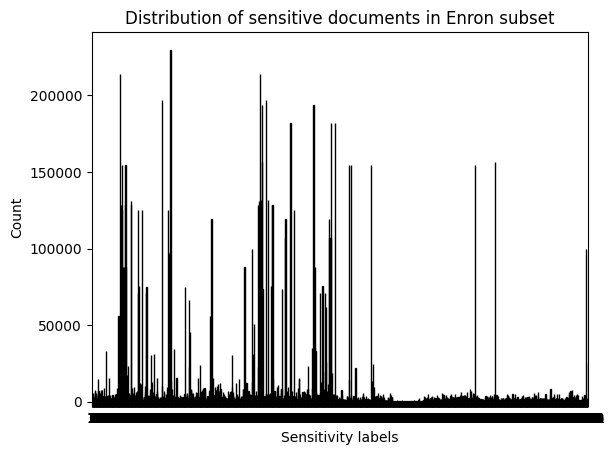

In [11]:
doc_lengths.plot(kind='bar', edgecolor='black')
plt.xlabel('Sensitivity labels')
plt.ylabel('Count')
plt.title('Distribution of sensitive documents in Enron subset')
plt.xticks(rotation=0)
plt.show()

In [12]:
doc_lengths

0        4697
1        2233
2        1192
3        5281
4        5419
        ...  
1697      835
1698     2299
1699     1551
1700     1564
1701    24948
Name: text, Length: 1702, dtype: int64

In [13]:
long_docs = sara_df[doc_lengths > 5000]

In [14]:
value_counts = long_docs.sensitivity.value_counts()
print(value_counts)

sensitivity
0    244
1     14
Name: count, dtype: int64


In [18]:
# Cannot load documents of length greater than ~12400. 109 problematic documents. However, longer documents begin to classify poorly.
cannot_load = sara_df[doc_lengths > 12400]
value_counts = cannot_load.sensitivity.value_counts()
print(value_counts)

sensitivity
0    100
1      9
Name: count, dtype: int64
